In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('notebook', {'highlight_selected_word': {
    'delay': 500,
    'code_cells_only': True,
}})


In [8]:
# train
import argparse
import logging
import math
import os
import sys
from typing import Dict, Optional, Any, List, Tuple, Callable

import numpy as np
import torch

from fairseq import (
    checkpoint_utils,
    distributed_utils,
    options,
    quantization_utils,
    tasks,
    utils,
)
from fairseq.data import iterators
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from fairseq.logging import meters, metrics, progress_bar
from fairseq.model_parallel.megatron_trainer import MegatronTrainer
from omegaconf import DictConfig
from fairseq.trainer import Trainer

# utils
import ast
import os
from argparse import ArgumentError, ArgumentParser, Namespace
from dataclasses import _MISSING_TYPE, MISSING
from enum import Enum
from typing import Any, Dict, List, Tuple, Type

from fairseq.dataclass import FairseqDataclass
from fairseq.dataclass.configs import FairseqConfig
from hydra.core.global_hydra import GlobalHydra
from hydra.experimental import compose, initialize
from omegaconf import DictConfig, OmegaConf, open_dict


In [9]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=os.environ.get("LOGLEVEL", "INFO").upper(),
    stream=sys.stdout,
)
logger = logging.getLogger("fairseq_cli.train")


In [4]:
def cli_main(modify_parser: Optional[Callable[[argparse.ArgumentParser], None]] = None) -> None:
    parser = options.get_training_parser()
    args = options.parse_args_and_arch(parser, modify_parser=modify_parser)

    cfg = convert_namespace_to_omegaconf(args)
#     print(cfg)
#     if args.profile:
#         with torch.cuda.profiler.profile():
#             with torch.autograd.profiler.emit_nvtx():
#                 distributed_utils.call_main(cfg, main)
#     else:
#         distributed_utils.call_main(cfg, main)
    return cfg


In [5]:
args = Namespace(activation='relu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, agg_zero_pad=False, aggregator='cnn', all_gather_list_size=16384, arch='wav2vec', balanced_classes=False, batch_size=None, batch_size_valid=None, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', clip_norm=25.0, combine_groups=False, conv_aggregator_layers='[(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]', conv_feature_layers='[(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]', cpu=False, criterion='wav2vec', cross_sample_negatives=0, curriculum=0, data='/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/', data_buffer_size=10, dataset_impl=None, ddp_backend='c10d', device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, distributed_wrapper='DDP', dropout=0.0, dropout_agg=0.0, dropout_features=0.0, empty_cache_freq=0, enable_padding=False, encoder='cnn', eos=2, fast_stat_sync=False, find_unused_parameters=False, finetune_from_model=None, fix_batches_to_gpus=False, fixed_validation_seed=None, fp16=True, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, gen_subset='test', gru_dim=512, infonce=False, keep_best_checkpoints=-1, keep_interval_updates=-1, keep_last_epochs=-1, labels=None, local_rank=0, localsgd_frequency=3, log_compression=True, log_format=None, log_interval=100, log_keys=None, loss_weights=None, lr=[1e-06], lr_period_updates=-1, lr_scheduler='cosine', lr_shrink=0.1, max_epoch=0, max_lr=0.005, max_sample_size=150000, max_tokens=1500000, max_tokens_valid=1500000, max_update=400000, maximize_best_checkpoint_metric=False, memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, min_lr=1e-09, min_sample_size=None, model_parallel_size=1, no_conv_bias=False, no_epoch_checkpoints=True, no_last_checkpoints=False, no_progress_bar=False, no_save=False, no_save_optimizer_state=False, no_seed_provided=False, non_affine_group_norm=False, normalize=False, nprocs_per_node=1, num_negatives=10, num_shards=1, num_workers=6, offset='auto', optimizer='adam', optimizer_overrides='{}', pad=1, patience=-1, pipeline_balance=None, pipeline_checkpoint='never', pipeline_chunks=0, pipeline_decoder_balance=None, pipeline_decoder_devices=None, pipeline_devices=None, pipeline_encoder_balance=None, pipeline_encoder_devices=None, pipeline_model_parallel=False, prediction_steps=12, profile=False, project_features='none', quantization_config_path=None, required_batch_size_multiple=8, required_seq_len_multiple=1, reset_dataloader=False, reset_lr_scheduler=False, reset_meters=False, reset_optimizer=False, residual_scale=0.5, restore_file='checkpoint_last.pt', sample_distance=None, sample_rate=16000, save_dir='./w2v_thn/w2v1109_/', save_interval=1, save_interval_updates=0, scoring='bleu', seed=1, sentence_avg=False, shard_id=0, skip_connections_agg=True, skip_connections_feat=False, skip_invalid_size_inputs_valid_test=True, slowmo_algorithm='LocalSGD', slowmo_momentum=None, stop_time_hours=0, t_mult=1.0, task='audio_pretraining', tensorboard_logdir=None, threshold_loss_scale=None, tokenizer=None, tpu=False, train_subset='train', unk=3, update_freq=[1], use_bmuf=False, use_old_adam=False, user_dir=None, valid_subset='valid', validate_after_updates=0, validate_interval=1, validate_interval_updates=0, vq_depth=1, vq_dim=0, vq_gamma=0.25, vq_groups=2, vq_temp='(2.0, 0.5, 0.999995)', vq_type='none', vq_vars=320, warmup_init_lr=1e-07, warmup_updates=500, weight_decay=0.0, zero_sharding='none')

In [6]:
cfg['task'].data

'/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/'

In [ ]:
/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/116-288045-0031.flac

In [ ]:
# from fairseq.data import AddTargetDataset, Dictionary, FileAudioDataset
# audio_dset = FileAudioDataset()

def __getitem__(self, index):
    import soundfile as sf

    fname = os.path.join(self.root_dir, self.fnames[index])
    wav, curr_sample_rate = sf.read(fname)
    feats = torch.from_numpy(wav).float()
    feats = self.postprocess(feats, curr_sample_rate)
    return {"id": index, "source": feats}



In [53]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt

fname = '/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/116-288045-0000.flac'
wav, curr_sample_rate = sf.read(fname)
feats = torch.from_numpy(wav).float()
 

In [54]:
wav.shape

(170400,)

In [208]:
sf.write('CREATED_Audio.flac', wav, 16000)

In [178]:
curr_sample_rate

16000

In [184]:
len(wav)

102481

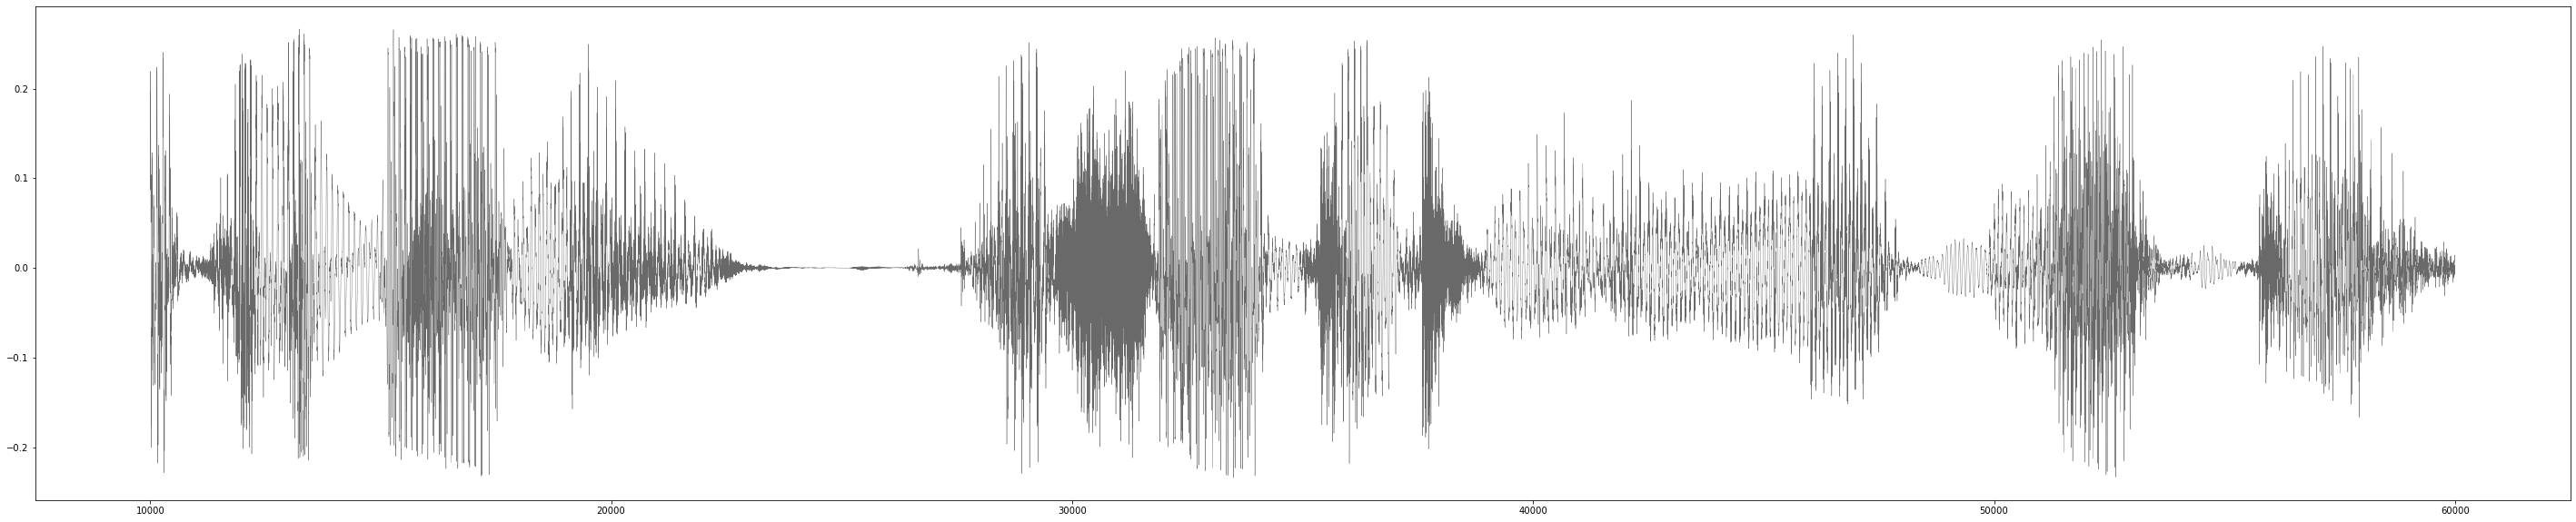

In [269]:
import matplotlib.pyplot as plt
import matplotlib

x = np.arange(0,len(wav))
i = 10000
l = 50000
plt.plot(x[i:i+l],wav[i:i+l],'k',color='#696969',linewidth=0.4,linestyle="-") 
plt.rcParams['figure.figsize'] = (50.0, 10.0) # 设置figure_size尺寸
# plt.grid('on')#标尺，on：有，off:无。
plt.show() #展示绘图


In [189]:
x.shape

(50,)

# mian's inputs

In [10]:
    args = Namespace(activation='relu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, agg_zero_pad=False, aggregator='cnn', all_gather_list_size=16384, arch='wav2vec', balanced_classes=False, batch_size=None, batch_size_valid=None, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', clip_norm=25.0, combine_groups=False, conv_aggregator_layers='[(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]', conv_feature_layers='[(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]', cpu=False, criterion='wav2vec', cross_sample_negatives=0, curriculum=0, data='/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/', data_buffer_size=10, dataset_impl=None, ddp_backend='c10d', device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, distributed_wrapper='DDP', dropout=0.0, dropout_agg=0.0, dropout_features=0.0, empty_cache_freq=0, enable_padding=False, encoder='cnn', eos=2, fast_stat_sync=False, find_unused_parameters=False, finetune_from_model=None, fix_batches_to_gpus=False, fixed_validation_seed=None, fp16=True, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, gen_subset='test', gru_dim=512, infonce=False, keep_best_checkpoints=-1, keep_interval_updates=-1, keep_last_epochs=-1, labels=None, local_rank=0, localsgd_frequency=3, log_compression=True, log_format=None, log_interval=100, log_keys=None, loss_weights=None, lr=[1e-06], lr_period_updates=-1, lr_scheduler='cosine', lr_shrink=0.1, max_epoch=0, max_lr=0.005, max_sample_size=150000, max_tokens=1500000, max_tokens_valid=1500000, max_update=400000, maximize_best_checkpoint_metric=False, memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, min_lr=1e-09, min_sample_size=None, model_parallel_size=1, no_conv_bias=False, no_epoch_checkpoints=True, no_last_checkpoints=False, no_progress_bar=False, no_save=False, no_save_optimizer_state=False, no_seed_provided=False, non_affine_group_norm=False, normalize=False, nprocs_per_node=1, num_negatives=10, num_shards=1, num_workers=6, offset='auto', optimizer='adam', optimizer_overrides='{}', pad=1, patience=-1, pipeline_balance=None, pipeline_checkpoint='never', pipeline_chunks=0, pipeline_decoder_balance=None, pipeline_decoder_devices=None, pipeline_devices=None, pipeline_encoder_balance=None, pipeline_encoder_devices=None, pipeline_model_parallel=False, prediction_steps=12, profile=False, project_features='none', quantization_config_path=None, required_batch_size_multiple=8, required_seq_len_multiple=1, reset_dataloader=False, reset_lr_scheduler=False, reset_meters=False, reset_optimizer=False, residual_scale=0.5, restore_file='checkpoint_last.pt', sample_distance=None, sample_rate=16000, save_dir='./w2v_thn/w2v1109_/', save_interval=1, save_interval_updates=0, scoring='bleu', seed=1, sentence_avg=False, shard_id=0, skip_connections_agg=True, skip_connections_feat=False, skip_invalid_size_inputs_valid_test=True, slowmo_algorithm='LocalSGD', slowmo_momentum=None, stop_time_hours=0, t_mult=1.0, task='audio_pretraining', tensorboard_logdir=None, threshold_loss_scale=None, tokenizer=None, tpu=False, train_subset='train', unk=3, update_freq=[1], use_bmuf=False, use_old_adam=False, user_dir=None, valid_subset='valid', validate_after_updates=0, validate_interval=1, validate_interval_updates=0, vq_depth=1, vq_dim=0, vq_gamma=0.25, vq_groups=2, vq_temp='(2.0, 0.5, 0.999995)', vq_type='none', vq_vars=320, warmup_init_lr=1e-07, warmup_updates=500, weight_decay=0.0, zero_sharding='none')
    cfg = convert_namespace_to_omegaconf(args)
    if isinstance(cfg, argparse.Namespace):
        cfg = convert_namespace_to_omegaconf(cfg)

    utils.import_user_module(cfg.common)

    assert cfg.dataset.max_tokens is not None or cfg.dataset.batch_size is not None, \
        'Must specify batch size either with --max-tokens or --batch-size'
    metrics.reset()

    np.random.seed(cfg.common.seed)
    utils.set_torch_seed(cfg.common.seed)

    if distributed_utils.is_master(cfg.distributed_training):
        checkpoint_utils.verify_checkpoint_directory(cfg.checkpoint.save_dir)

    # Print args
    logger.info(cfg)

    # Setup task, e.g., translation, language modeling, etc.
    task = tasks.setup_task(cfg.task)
    # Load valid dataset (we load training data below, based on the latest checkpoint)
    for valid_sub_split in cfg.dataset.valid_subset.split(','):
        print('valid_sub_split:', valid_sub_split)
        task.load_dataset(valid_sub_split, combine=False, epoch=1)



2021-01-09 12:02:12 | INFO | fairseq_cli.train | {'common': {'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'memory_efficient_bf16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False}, 'distributed_training': {'distributed_rank': 0, 'distributed_backend': 'nccl', 'distributed_init_method': None, 'distributed_port': -1, 'device_id': 0, 'local_rank': 0, 'distributed_no_spawn': False, 'ddp_backend': 'c10d', 'bucket_cap_mb': 25, 'fix_batches_to_gpus': False, 'find_unused_parameters': False, 'fast_stat_sync': False, 'broadcast_buffers': False, 'distributed_wrapper': 'DDP', 'sl

valid_sub_split: valid
manifest_path: /home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/valid.tsv

 ['116-288045-0009.flac', '49120']
2021-01-09 12:02:12 | INFO | fairseq.data.audio.raw_audio_dataset | loaded 1, skipped 0 samples
2021-01-09 12:02:12 | INFO | fairseq.data.audio.raw_audio_dataset | ['116-288045-0009.flac']


In [19]:
cfg.criterion

Namespace(_name='wav2vec', activation='relu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, agg_zero_pad=False, aggregator='cnn', all_gather_list_size=16384, arch='wav2vec', balanced_classes=False, batch_size=None, batch_size_valid=None, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', clip_norm=25.0, combine_groups=False, conv_aggregator_layers='[(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]', conv_feature_layers='[(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]', cpu=False, criterion='wav2vec', cross_sample_negatives=0, curriculum=0, data='/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/', data_buffer_size=10, dataset_impl=None, ddp_backend='c10d', device_id=0, disable_validation=False, distributed_backend='nccl', distributed_ini

In [20]:
task = tasks.setup_task(cfg.task)

In [ ]:
task.load_dataset('train', combine=False, epoch=1)

In [50]:
task.datasets['train'].__getitem__(1)['source'].shape

2021-01-09 18:46:41 | INFO | fairseq.data.audio.raw_audio_dataset |  ****|source_audio_file_sz|:torch.Size([78320])


torch.Size([78320])

In [51]:
cfg.dataset.valid_subset.split(',')

['valid']

In [135]:
task.load_dataset(valid_sub_split, combine=False, epoch=1)

2020-11-26 22:26:23 | INFO | fairseq.data.audio.raw_audio_dataset | loaded 1, skipped 0 samples


In [117]:
valid_sub_split

'valid'

In [121]:
cfg.dataset

{'num_workers': 6, 'skip_invalid_size_inputs_valid_test': True, 'max_tokens': 1500000, 'batch_size': None, 'required_batch_size_multiple': 8, 'dataset_impl': None, 'data_buffer_size': 10, 'train_subset': 'train', 'valid_subset': 'valid', 'validate_interval': 1, 'fixed_validation_seed': None, 'disable_validation': False, 'curriculum': 0, 'gen_subset': 'test', 'num_shards': 1, 'shard_id': 0, 'max_tokens_valid': 1500000, 'batch_size_valid': None, 'required_seq_len_multiple': 1, 'validate_interval_updates': 0, 'validate_after_updates': 0}

In [111]:
args = Namespace(activation='relu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, agg_zero_pad=False, aggregator='cnn', all_gather_list_size=16384, arch='wav2vec', balanced_classes=False, batch_size=None, batch_size_valid=None, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', clip_norm=25.0, combine_groups=False, conv_aggregator_layers='[(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]', conv_feature_layers='[(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]', cpu=False, criterion='wav2vec', cross_sample_negatives=0, curriculum=0, data='/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/', data_buffer_size=10, dataset_impl=None, ddp_backend='c10d', device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, distributed_wrapper='DDP', dropout=0.0, dropout_agg=0.0, dropout_features=0.0, empty_cache_freq=0, enable_padding=False, encoder='cnn', eos=2, fast_stat_sync=False, find_unused_parameters=False, finetune_from_model=None, fix_batches_to_gpus=False, fixed_validation_seed=None, fp16=True, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, gen_subset='test', gru_dim=512, infonce=False, keep_best_checkpoints=-1, keep_interval_updates=-1, keep_last_epochs=-1, labels=None, local_rank=0, localsgd_frequency=3, log_compression=True, log_format=None, log_interval=100, log_keys=None, loss_weights=None, lr=[1e-06], lr_period_updates=-1, lr_scheduler='cosine', lr_shrink=0.1, max_epoch=0, max_lr=0.005, max_sample_size=150000, max_tokens=1500000, max_tokens_valid=1500000, max_update=400000, maximize_best_checkpoint_metric=False, memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, min_lr=1e-09, min_sample_size=None, model_parallel_size=1, no_conv_bias=False, no_epoch_checkpoints=True, no_last_checkpoints=False, no_progress_bar=False, no_save=False, no_save_optimizer_state=False, no_seed_provided=False, non_affine_group_norm=False, normalize=False, nprocs_per_node=1, num_negatives=10, num_shards=1, num_workers=6, offset='auto', optimizer='adam', optimizer_overrides='{}', pad=1, patience=-1, pipeline_balance=None, pipeline_checkpoint='never', pipeline_chunks=0, pipeline_decoder_balance=None, pipeline_decoder_devices=None, pipeline_devices=None, pipeline_encoder_balance=None, pipeline_encoder_devices=None, pipeline_model_parallel=False, prediction_steps=12, profile=False, project_features='none', quantization_config_path=None, required_batch_size_multiple=8, required_seq_len_multiple=1, reset_dataloader=False, reset_lr_scheduler=False, reset_meters=False, reset_optimizer=False, residual_scale=0.5, restore_file='checkpoint_last.pt', sample_distance=None, sample_rate=16000, save_dir='./w2v_thn/w2v1109_/', save_interval=1, save_interval_updates=0, scoring='bleu', seed=1, sentence_avg=False, shard_id=0, skip_connections_agg=True, skip_connections_feat=False, skip_invalid_size_inputs_valid_test=True, slowmo_algorithm='LocalSGD', slowmo_momentum=None, stop_time_hours=0, t_mult=1.0, task='audio_pretraining', tensorboard_logdir=None, threshold_loss_scale=None, tokenizer=None, tpu=False, train_subset='train', unk=3, update_freq=[1], use_bmuf=False, use_old_adam=False, user_dir=None, valid_subset='valid', validate_after_updates=0, validate_interval=1, validate_interval_updates=0, vq_depth=1, vq_dim=0, vq_gamma=0.25, vq_groups=2, vq_temp='(2.0, 0.5, 0.999995)', vq_type='none', vq_vars=320, warmup_init_lr=1e-07, warmup_updates=500, weight_decay=0.0, zero_sharding='none')
cfg = convert_namespace_to_omegaconf(args)

In [112]:
cfg.common

{'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'memory_efficient_bf16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False}

In [ ]:
modify_parser = None
parser = options.get_training_parser()
args = options.parse_args_and_arch(parser, modify_parser=modify_parser)


In [105]:
parser

ArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

# Embedding Output

In [ ]:
file = './output/test/116-288045-0000.h5'
./output/test/116-288045-0001.h5

In [329]:
import h5py#HDF5的读取：  
f = h5py.File('./output/test/116-288045-0001.h5','r')   #打开h5文件  # 可以查看所有的主键  
for key in f.keys():      
    print(f[key].name)      
    print(f[key].shape)      
#     print(f[key].value)


/features
(440832,)
/info
(3,)


In [399]:
#  定义绘制一维向量的函数

def plot_curve(y: np.ndarray, i = 0, j = 0) -> None:
    import matplotlib.pyplot as plt
    import matplotlib
    x = np.arange(0,len(y))
    if j == 0: 
        j = len(y)        
    # i = 10000
    # l = 50000
    plt.plot(x[i: i + j], y[i: i + j],'k',color='#696969', linewidth=0.4, linestyle="-") 
    plt.rcParams['figure.figsize'] = (50.0, 10.0) # 设置figure_size尺寸
    # plt.grid('on')#标尺，on：有，off:无。
    plt.show() #展示绘图

# Load Audio File.flac

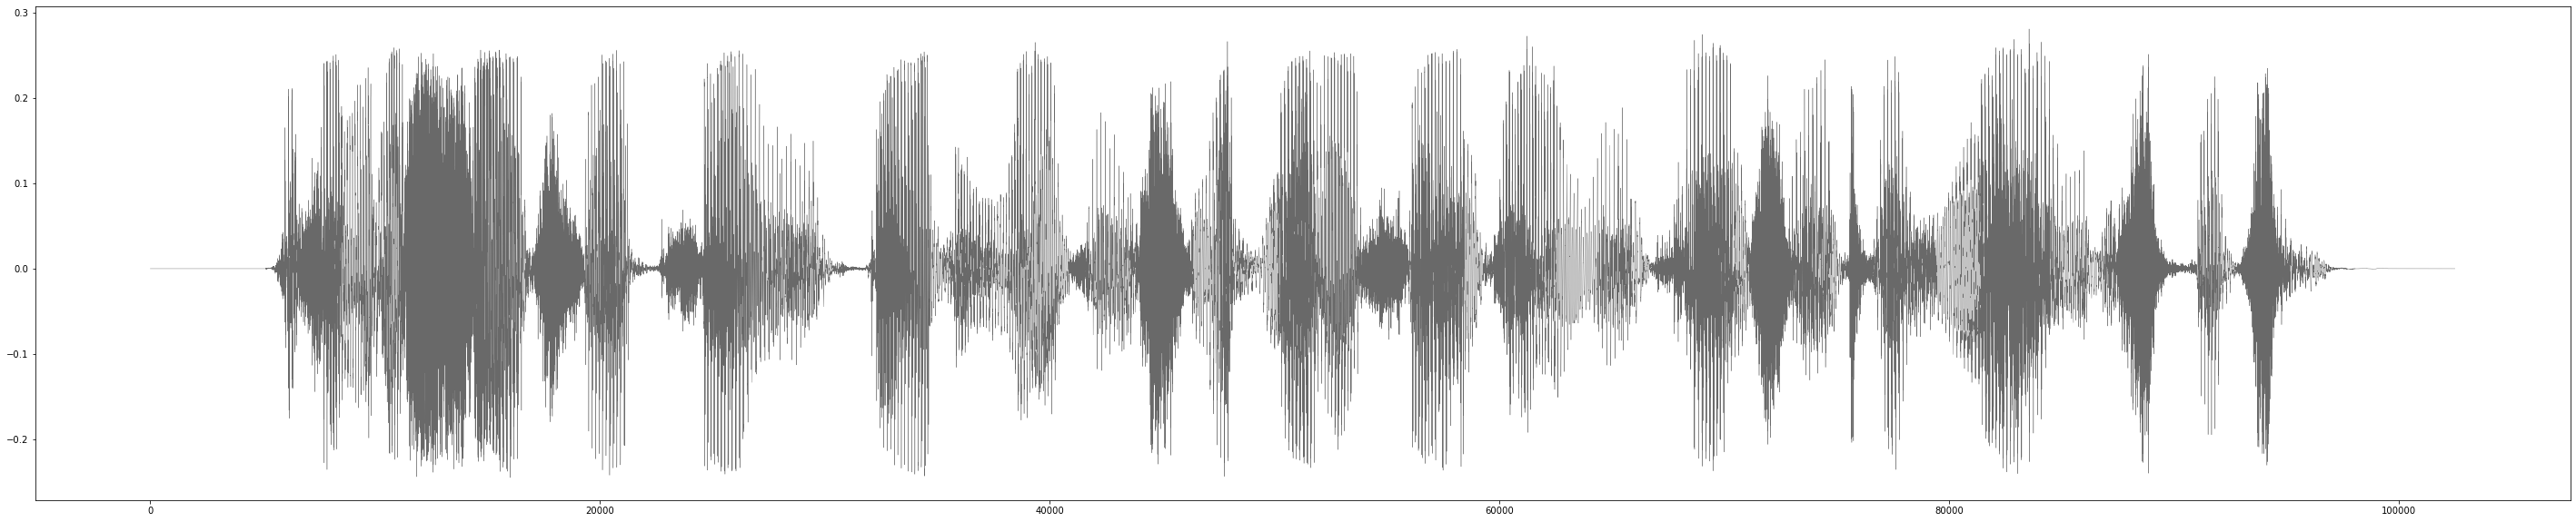

In [411]:
fname = '/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/116-288045-0025.flac'
wav, curr_sample_rate = sf.read(fname)
plot_curve(wav)

In [412]:
wav.shape

(102481,)

### load pre-trained model

In [431]:
print(model.vector_quantizer)

None


In [413]:
import torch
from fairseq.models.wav2vec import Wav2VecModel

cp = torch.load('./w2v_thn/wav2vec_large.pt')
model = Wav2VecModel.build_model(cp['args'], task=None)
model.load_state_dict(cp['model'])
model.eval()


2020-12-01 16:35:50 | INFO | fairseq.models.wav2vec.w2vdecoder | Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupN

Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
 

In [409]:
feats.shape

torch.Size([1, 170400])

In [434]:
# wav_input_16khz = torch.randn(1,10000)
feats = torch.from_numpy(wav).float()
feats = feats.view(1, -1)
z = model.feature_extractor(feats)
z_ = model.dropout_feats(z)
c = model.feature_aggregator(z_)
c_ = model.dropout_agg(c)
# c = model.feature_aggregator(z)
# c_x = model.dropout_agg(c)
#         
# features = model.feature_extractor(source)
label, target = model.wav2vec_predictions(c_, z)
print(feats.shape)
print(z.shape)
print(c.shape)
print(label.shape)
print(target.shape)

torch.Size([1, 102481])
torch.Size([1, 512, 638])
torch.Size([1, 512, 638])
torch.Size([83094])
torch.Size([83094])


In [442]:
c.detach().numpy().shape[0]

512

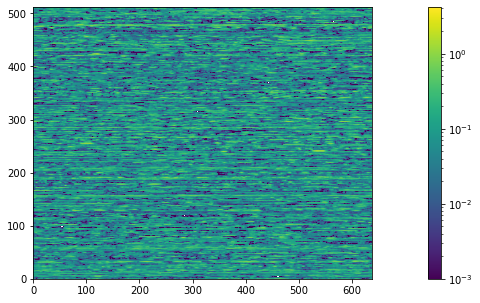

In [481]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np
# x, y = np.random.rand(10), np.random.rand(10)
# z = (np.random.rand(9000000)+np.linspace(0,1, 9000000)).reshape(3000, 3000)
plt.imshow(c.detach().numpy(), extent=(0, c.detach().numpy().shape[0], 0, c.detach().numpy().shape[1]), \
    norm=LogNorm(0.001))
plt.rcParams['figure.figsize'] = (50.0, 5.0) # 设置figure_size尺寸

plt.colorbar()
plt.show()

In [370]:
c = c.view(512, -1)
z = z.view(512, -1)
z.shape

torch.Size([512, 1063])

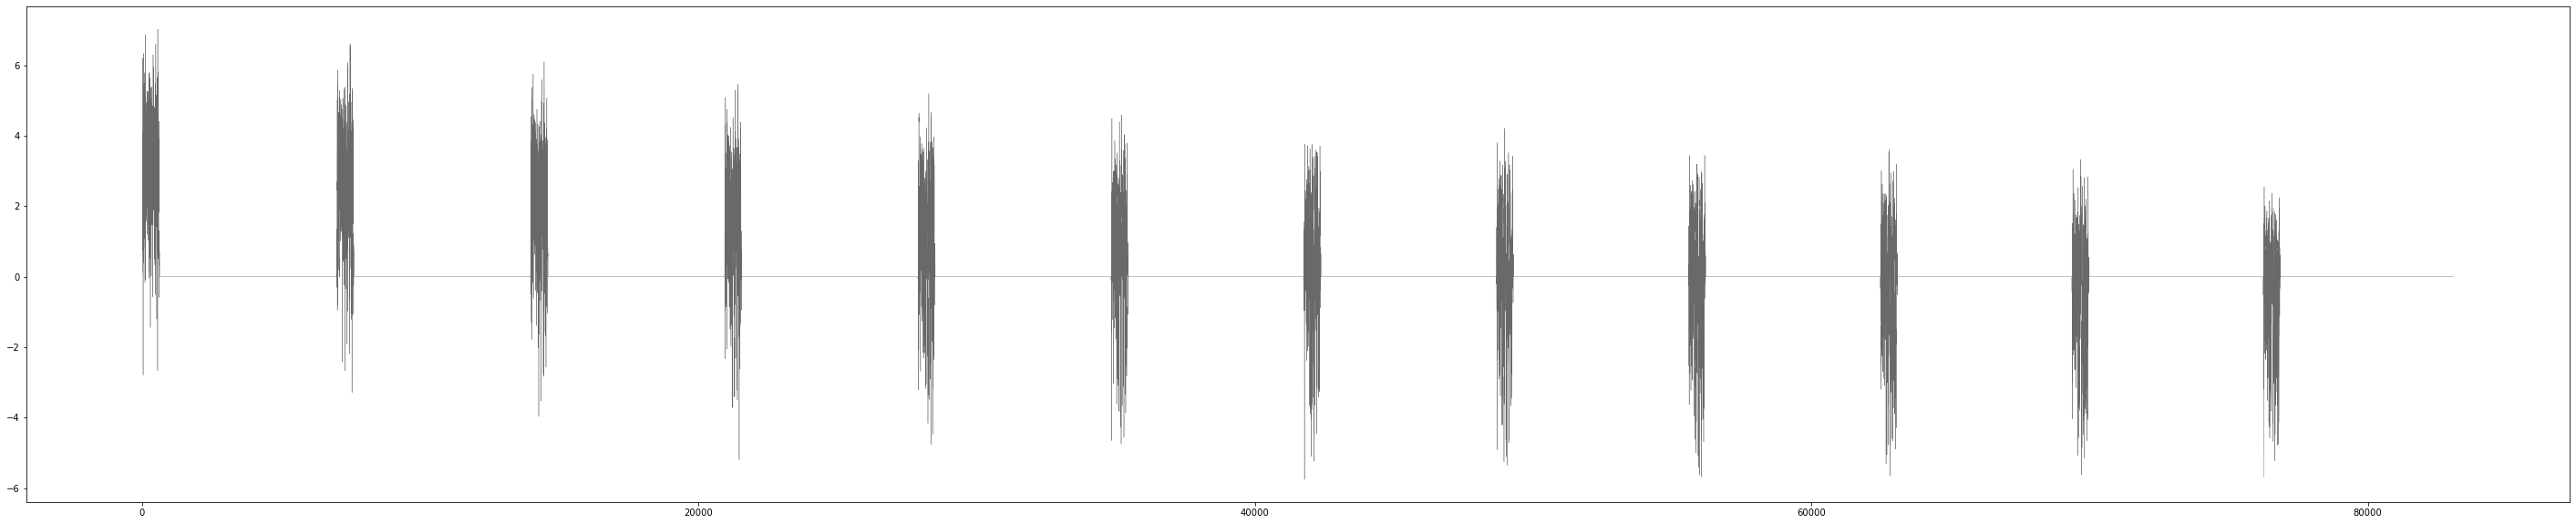

In [420]:
plot_curve((label*target).detach().numpy())

In [422]:
pred_out = (label*target).detach().numpy()
sf.write('pred_out.flac', pred_out, 16000)

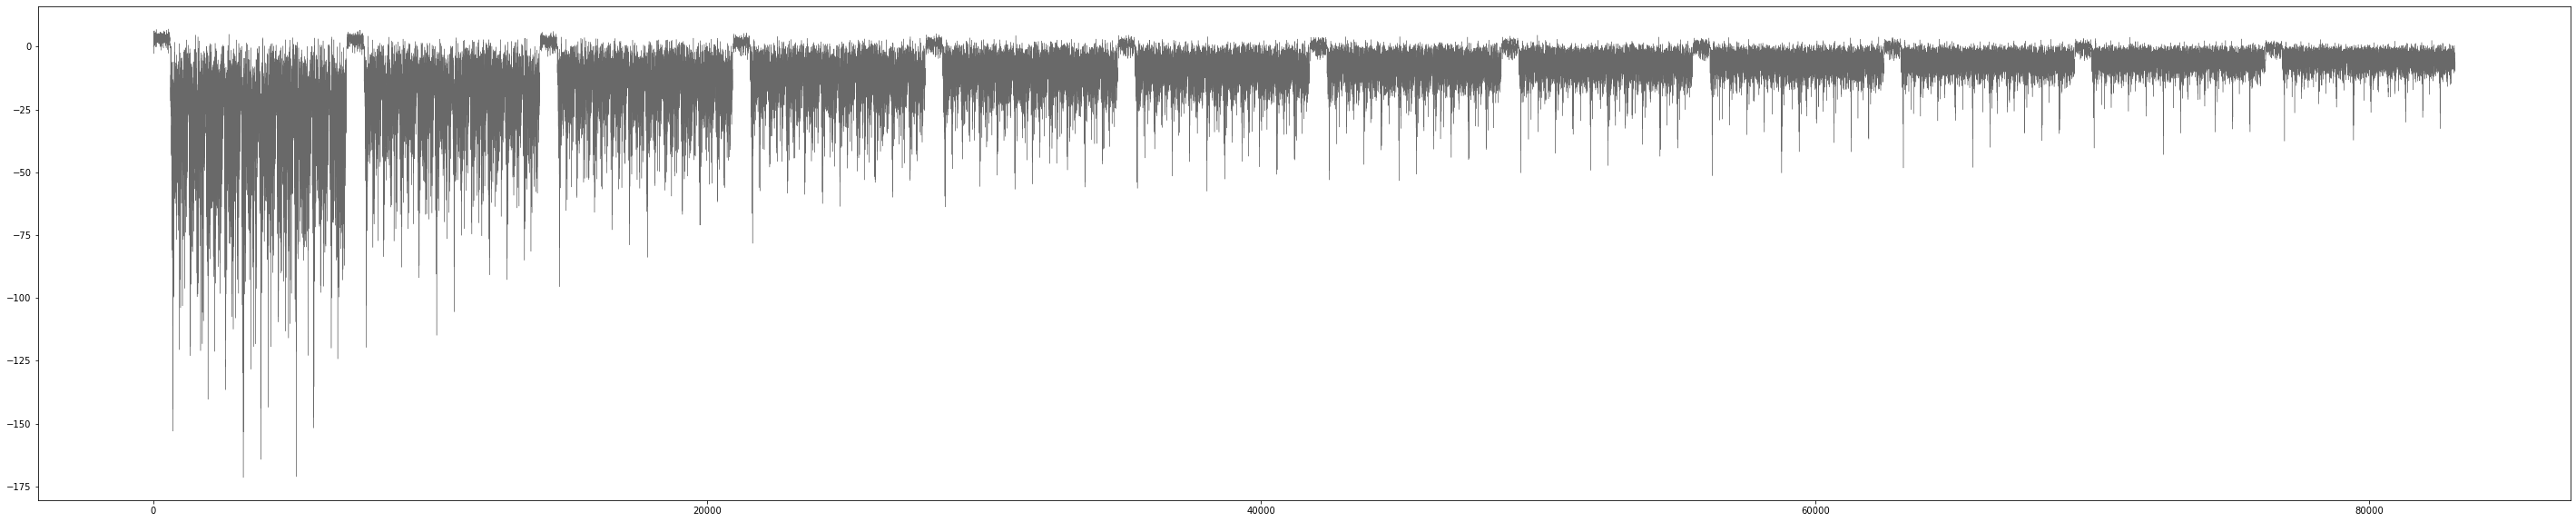

In [415]:
plot_curve(cpc_logits.view(-1).detach().numpy() )

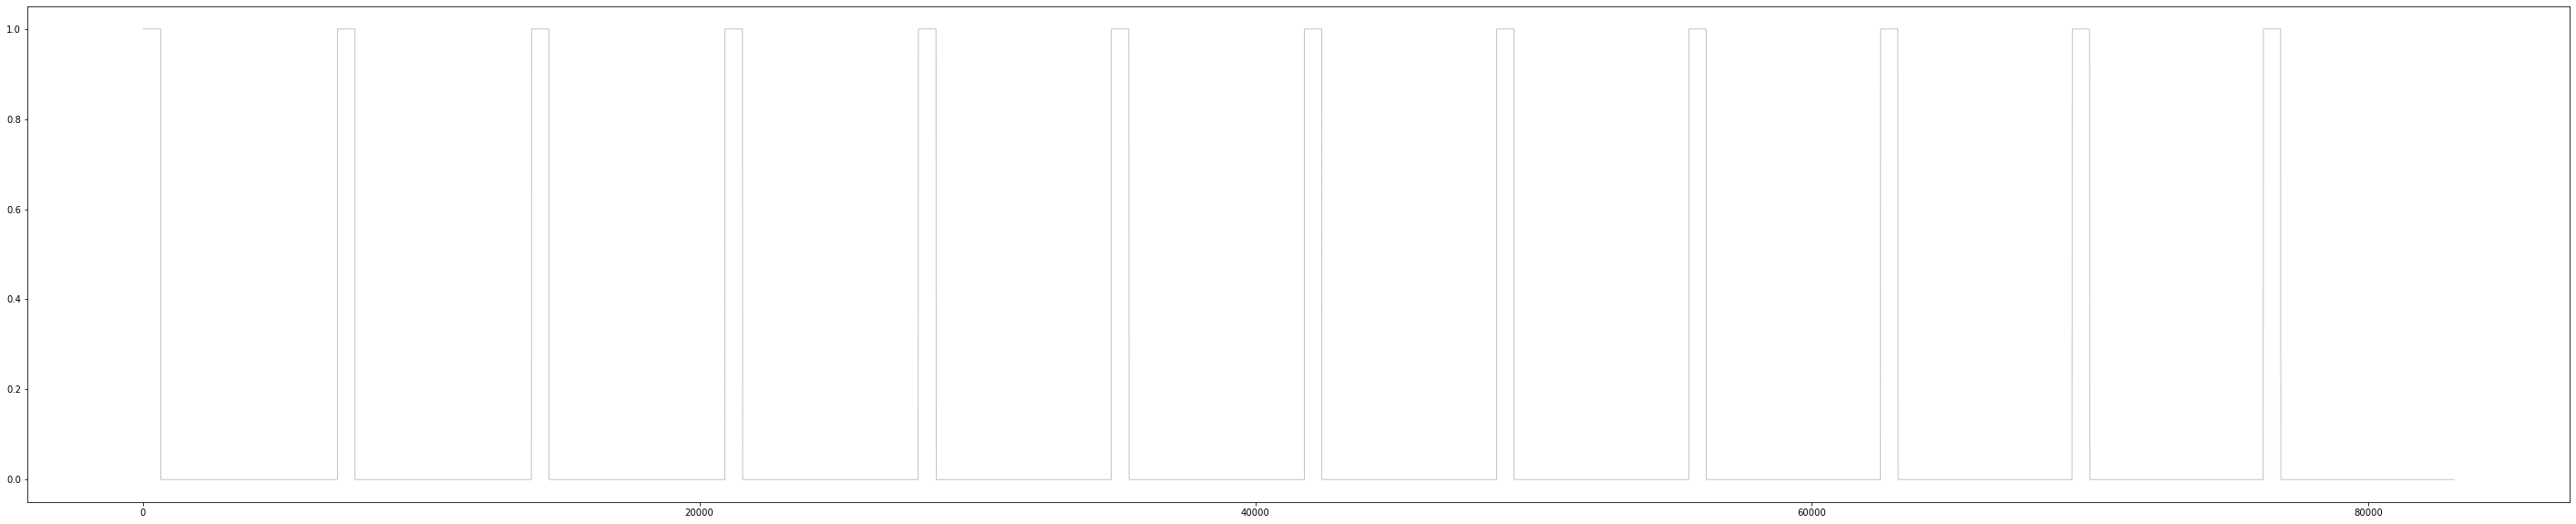

In [416]:
plot_curve(cpc_target.view(-1).detach().numpy() )

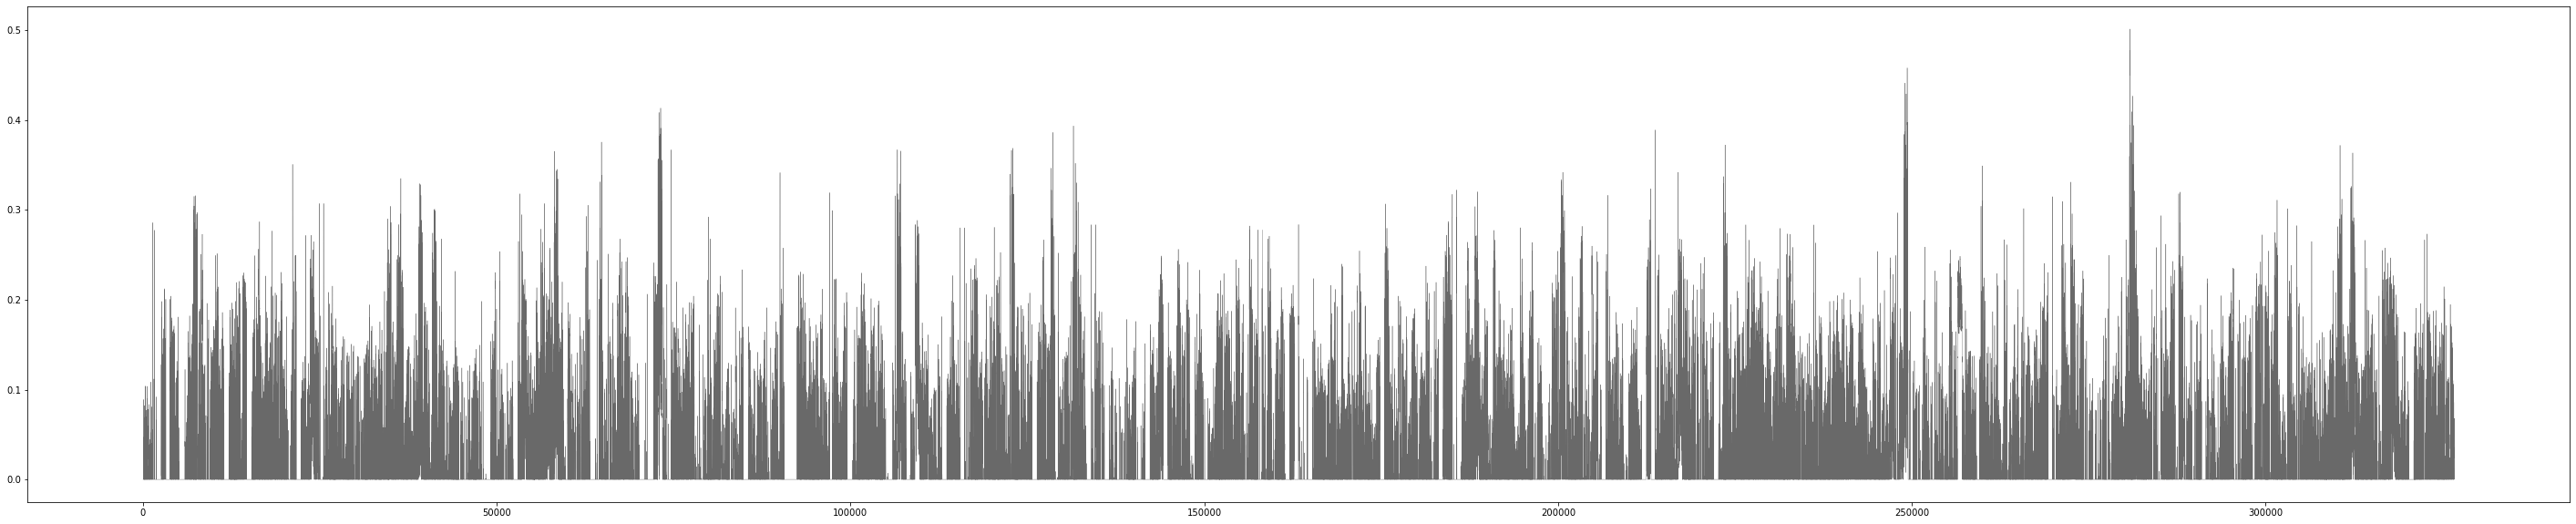

In [437]:
plot_curve(z_.view(-1).detach().numpy() )

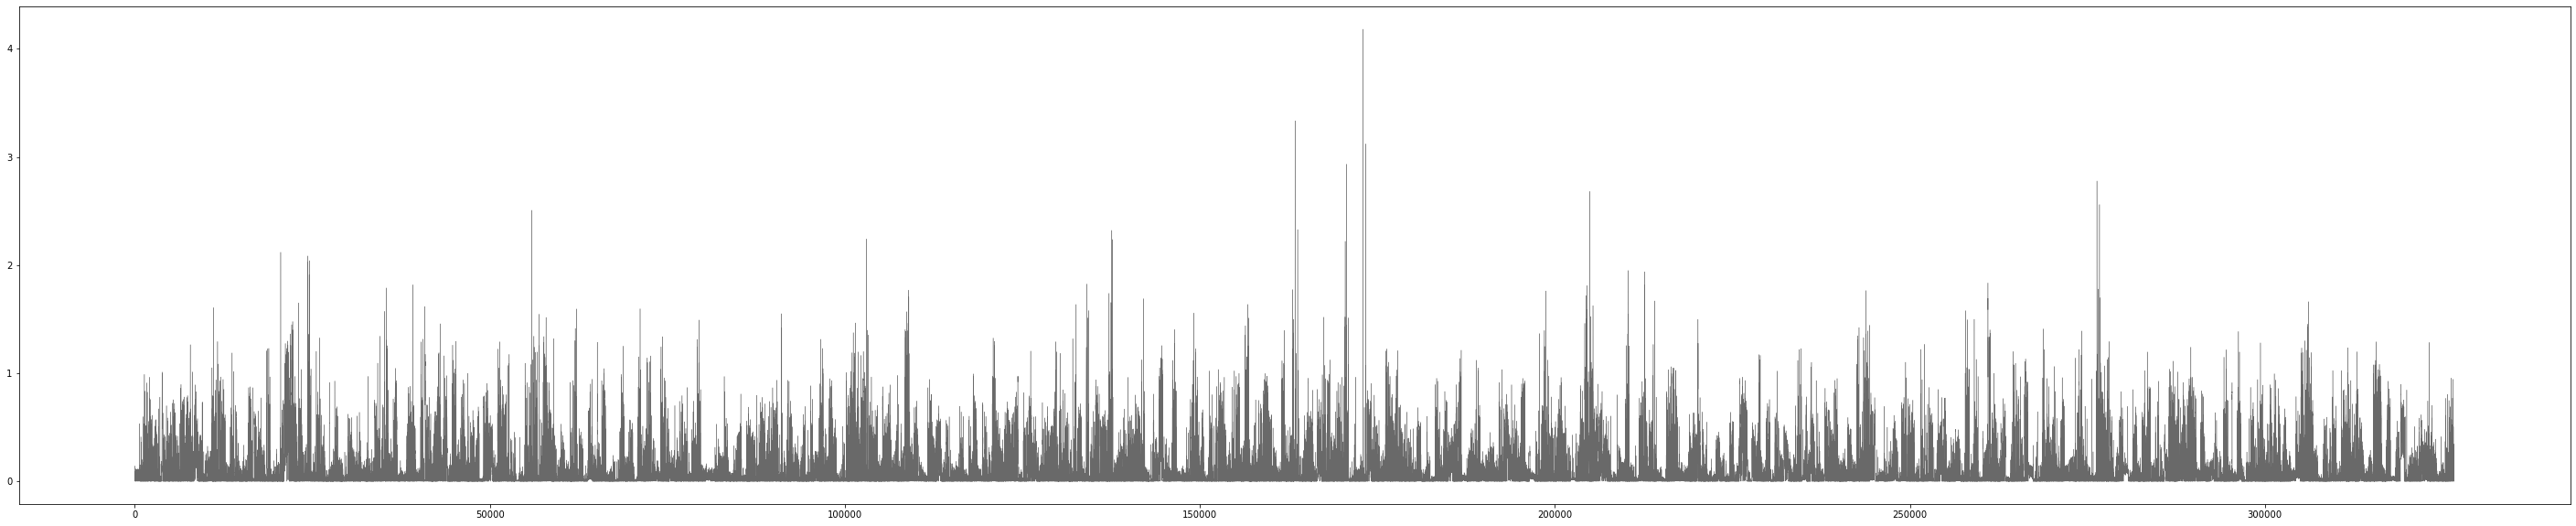

In [485]:
plot_curve(c_.view(-1).detach().numpy())

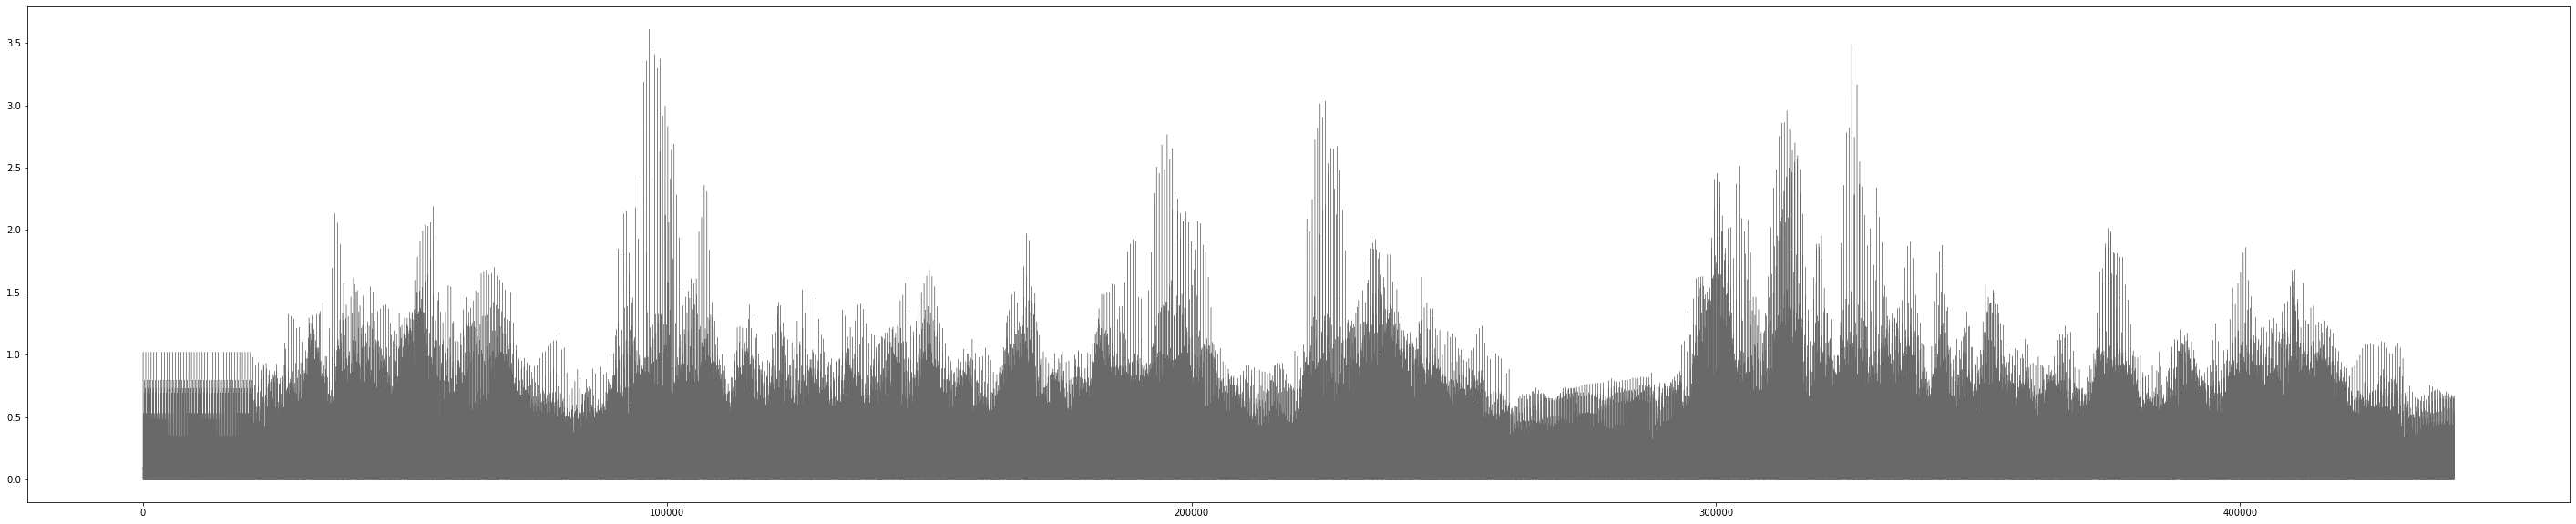

In [334]:
emb_dset = f['features']
emb_data = np.array(emb_dset[:])
plot_curve(emb_data)

In [373]:
emb_data.shape

(440832,)

In [274]:
sf.write('embedding_audio.flac', emb_data, 16000)

In [247]:
f.keys()

<KeysViewHDF5 ['features', 'info']>

In [264]:
f['features']

<HDF5 dataset "features": shape (544256,), type "<f4">

In [308]:
f['info'].visit

AttributeError: 'Dataset' object has no attribute 'visit'

# Load Model 

In [286]:
wav_input_16khz.shape

torch.Size([1, 10000])

In [284]:
z.shape

torch.Size([1, 512, 60])

In [283]:
c.shape

torch.Size([1, 512, 60])

In [287]:
512*60 / 10000

3.072

In [277]:
!pwd

/home/thn/Harlan_Thomas/wave2vec


# Train CLI

In [106]:
! python train.py ~/audio_dataset/LibriSpeech/dev-other/116/288045/ --save-dir ./w2v_thn/w2v1109_/ --num-workers 6 --fp16 --max-update 400000 --save-interval 1 --no-epoch-checkpoints --arch wav2vec --task audio_pretraining --lr 1e-06 --min-lr 1e-09 --optimizer adam --max-lr 0.005 --lr-scheduler cosine --conv-feature-layers '[(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]' --conv-aggregator-layers '[(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]' --skip-connections-agg --residual-scale 0.5 --log-compression --warmup-updates 500 --warmup-init-lr 1e-07 --criterion wav2vec --num-negatives 10 --max-sample-size 150000 --max-tokens 1500000 --skip-invalid-size-inputs-valid-test


parser: ArgumentParser(prog='train.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

 modify_parser None
args Namespace(activation='relu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, agg_zero_pad=False, aggregator='cnn', all_gather_list_size=16384, arch='wav2vec', balanced_classes=False, batch_size=None, batch_size_valid=None, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', clip_norm=25.0, combine_groups=False, conv_aggregator_layers='[(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]', conv_feature_layers='[(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]', cpu=False, criterion='wav2vec', cross_sample_negatives=0, curriculum=0, data='/home/thn/audio_dataset/LibriSpe

2020-11-26 21:28:15 | INFO | fairseq.models.wav2vec.wav2vec | Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm

2020-11-26 21:28:17 | INFO | fairseq.trainer | detected shared parameter: feature_extractor.conv_layers.0.0.bias <- feature_extractor.conv_layers.1.0.bias
2020-11-26 21:28:17 | INFO | fairseq.trainer | detected shared parameter: feature_extractor.conv_layers.0.0.bias <- feature_extractor.conv_layers.2.0.bias
2020-11-26 21:28:17 | INFO | fairseq.trainer | detected shared parameter: feature_extractor.conv_layers.0.0.bias <- feature_extractor.conv_layers.3.0.bias
2020-11-26 21:28:17 | INFO | fairseq.trainer | detected shared parameter: feature_extractor.conv_layers.0.0.bias <- feature_extractor.conv_layers.4.0.bias
2020-11-26 21:28:17 | INFO | fairseq.trainer | detected shared parameter: feature_extractor.conv_layers.0.0.bias <- feature_extractor.conv_layers.5.0.bias
2020-11-26 21:28:17 | INFO | fairseq.trainer | detected shared parameter: feature_extractor.conv_layers.0.0.bias <- feature_extractor.conv_layers.6.0.bias
2020-11-26 21:28:17 | INFO | fairseq.utils | ***********************CU

In [1]:
!nvidia-smi

Wed Nov 25 23:24:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:68:00.0  On |                  N/A |
| 40%   36C    P8    28W / 280W |   5347MiB / 24217MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
cfg